# Image Clustering with FFT

## Download the data set
* Download CIFAR-10 from https://www.cs.toronto.edu/~kriz/cifar.html
* Unzip the tar into the same dir as this notebook

In [1]:
import numpy as np
import pickle
import matplotlib.pyplot as plt

In [2]:
N_PIXELS = 32 # width and height of each CIFAR image
N_CHANNELS = 3 # depth of each CIFAR image

In [3]:
def load_CIFAR_batch(path):
    """
    Loads a single CIFAR-10 batch from the given path.
    """
    with open(path, mode="rb") as f:
        raw = pickle.load(f, encoding="bytes")
        raw_images = raw[b'data']
        labels = raw[b'labels']
    return np.array(raw_images), np.array(labels)

In [4]:
def reshape_images(raw_images):
    """
    Converts the array of raw (3072,) shaped images into an
    array of (32, 32, 3) shaped images.
    """
    images = np.array(raw_images, dtype=float) / 255.0
    images = images.reshape([-1, N_CHANNELS, N_PIXELS, N_PIXELS])
    images = images.transpose([0, 2, 3, 1])
    return images

In [5]:
# check if we can load the first batch
images, labels = load_CIFAR_batch("cifar-10-batches-py/data_batch_1")
images = reshape_images(images)

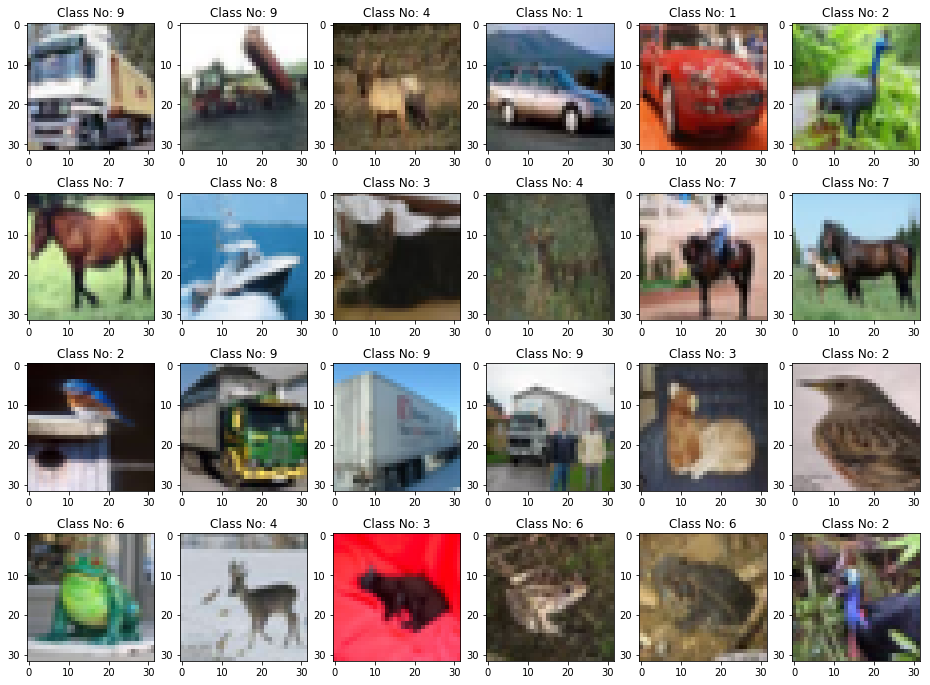

In [6]:
# check we've read/transformed our images correctly
fig = plt.figure(figsize=[16, 12])
cols = 6
rows = 4
for i in range(1, rows*cols+1):
    img = images[i]
    subplt = fig.add_subplot(rows, cols, i)
    subplt.set_title("Class No: " + str(labels[i]))
    plt.imshow(img)
plt.show()

## Fast fourier transformations (FFT)

In [7]:
def fft_transform(image):
    """
    Applies FFT to an RBG image with dims (N_PIXEL_ROWS, N_PIXEL_COLS, N_CHANNELS).
    """
    # CIFAR-10 images are in RGB by default, but FFT needs them in greyscale
    image = np.dot(image[...,:3], [0.299, 0.587, 0.114])
    
    # perform the transformation
    f = np.fft.fft2(image)
    
    # by default, zero-frequency component is in top-left, move to center
    fshift = np.fft.fftshift(f)
    
    # can't remember the reason for the log transform
    # -- I think it's something like all the values are too high, so the
    # -- FFT version of most images will look all black
    magnitude_spectrum = np.log(np.abs(fshift))
    
    return magnitude_spectrum

In [8]:
fft_images = [fft_transform(img) for img in images]

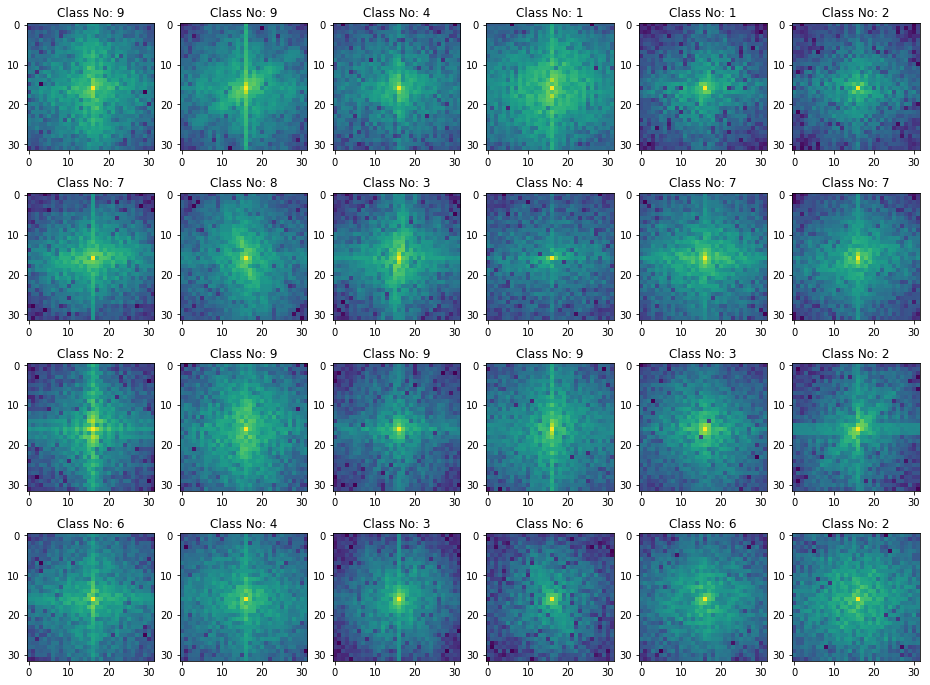

In [9]:
# double check by plotting the first few images again
fig = plt.figure(figsize=[16, 12])
cols = 6
rows = 4
for i in range(1, rows*cols+1):
    img = fft_images[i]
    subplt = fig.add_subplot(rows, cols, i)
    subplt.set_title("Class No: " + str(labels[i]))
    plt.imshow(img)
plt.show()

## Run clustering on the FFT transformations

In [10]:
from sklearn.cluster import KMeans

In [11]:
# prepare the FFT images for training -- flatten to (32 * 32) feature vectors
train = [img.flatten() for img in fft_images]

In [12]:
# instantiate the clusterer - randomly choosing 20 clusters
# -- this is something you would have to determine a proiri or
# -- would have to run the algorithm a bunch of times to see which does better
kmeans = KMeans(n_clusters=20)

In [13]:
# train it on the flattened FFT images
kmeans.fit(train)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=20, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [14]:
# attach a cluster id to each of the images
cluster_ids = kmeans.predict(train)

## Check how we did with the original images

In [15]:
from collections import defaultdict

In [16]:
# group the images that belong to each cluster
clusters = defaultdict(list)
for i in range(len(images)):
    clusters[ cluster_ids[i] ].append(images[i])

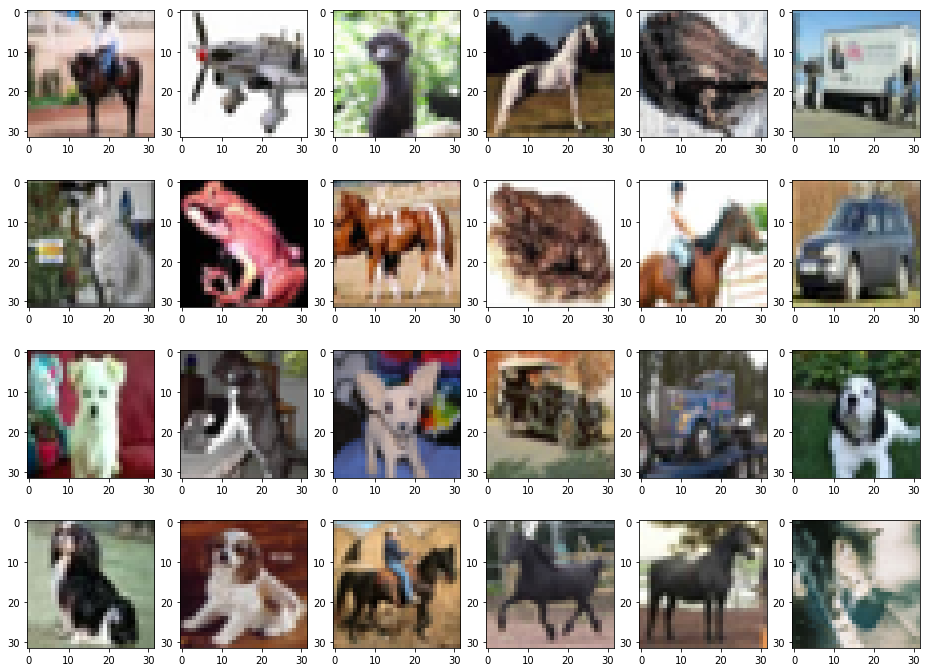

In [20]:
# take a look at a sample of the images in one of the clusters
fig = plt.figure(figsize=[16, 12])
cols = 6
rows = 4
for i in range(1, rows*cols+1):
    img = clusters[2][i]
    subplt = fig.add_subplot(rows, cols, i)
    plt.imshow(img)
plt.show()

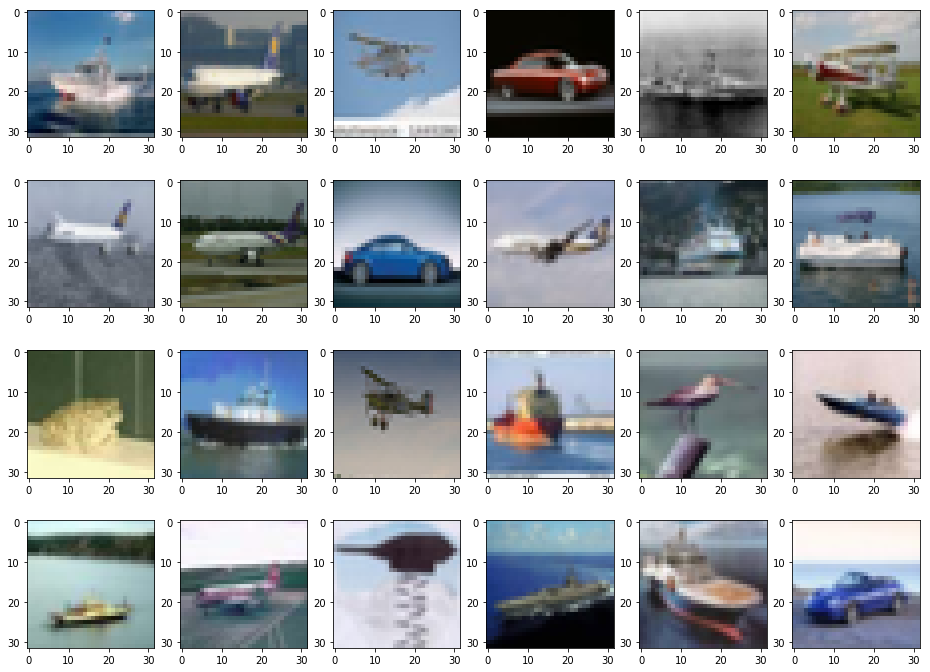

In [21]:
# likewise for some other cluster
fig = plt.figure(figsize=[16, 12])
cols = 6
rows = 4
for i in range(1, rows*cols+1):
    img = clusters[3][i]
    subplt = fig.add_subplot(rows, cols, i)
    plt.imshow(img)
plt.show()